In [ ]:
from __future__ import print_function
import numpy as np
from keras.models import load_model

In [16]:
import urllib
import scipy.optimize
import random
from collections import defaultdict
import string
from sklearn.metrics import accuracy_score ,confusion_matrix
import keras
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation, InputLayer, Flatten, Reshape
from keras.layers.normalization import BatchNormalization
from keras.optimizers import SGD
import tensorflow as tf
import os
from matplotlib import pyplot
import tools
from keras.layers.convolutional import Conv2D, MaxPooling2D
from keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img

In [17]:
config = tf.ConfigProto( device_count = {'GPU': 1 , 'CPU': 56} ) 
sess = tf.Session(config=config) 
keras.backend.set_session(sess)


### Load Data

In [18]:
xtrain,ltrain = tools.load(dataset = "training", path = "./FashionMNIST")
xtest, ltest  = tools.load(dataset = "testing",  path = "./FashionMNIST")

### Normalization

In [19]:
def normalize_MNIST_images(x):
    x = x.astype('float64')
    x = x*((2.0/255))-1
    return x

def label2onehot(lbl):
    d = np.zeros((lbl.max() + 1, lbl.size))
    d[lbl, np.arange(0, lbl.size)] = 1
    return d

In [20]:
xtrain = normalize_MNIST_images(xtrain)
xtest = normalize_MNIST_images(xtest)

In [21]:
dtrain = label2onehot(ltrain)
dtest = label2onehot(ltest)

In [22]:
xtrain=xtrain.reshape(28, 28, 1, 60000)
xtest=xtest.reshape(28, 28, 1, 10000)

In [25]:
xtrain = np.moveaxis(xtrain, [3] ,[0])
xtest = np.moveaxis(xtest, [3] ,[0])

### 1st Net

In [29]:
model = Sequential()

model.add(InputLayer(input_shape=( 28, 28, 1)))
model.add(BatchNormalization())
model.add(Conv2D(64, (5, 5), input_shape = ( 60000, 28, 28, 1), activation = 'relu',bias_initializer='RandomNormal', kernel_initializer='random_uniform'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(BatchNormalization())
model.add(Conv2D(512, (5, 5), activation = 'relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Flatten())
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.35))
model.add(Dense(64, activation='relu'))
model.add(Dropout(0.35))
model.add(Dense(10, activation='softmax'))

print(model.summary())

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 28, 28, 1)         0         
_________________________________________________________________
batch_normalization_1 (Batch (None, 28, 28, 1)         4         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 24, 24, 64)        1664      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 12, 12, 64)        0         
_________________________________________________________________
batch_normalization_2 (Batch (None, 12, 12, 64)        256       
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 8, 8, 512)         819712    
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 4, 4, 512)         0         
__________

In [30]:
from keras.optimizers import Adam
opt = Adam(decay=0.001)

In [31]:
model.compile(optimizer=opt,
              loss='categorical_crossentropy',
              metrics=['accuracy'])

In [34]:
import time
start_time = time.time()
epochs=20
batch_size=64
training = model.fit(xtrain, dtrain.T,
                     epochs=epochs,
                     batch_size=batch_size, 
                     verbose=1, validation_split=0.2)
training_time = time.time() - start_time

Train on 48000 samples, validate on 12000 samples
Epoch 1/20
48000/48000 [==============================] - 14s 287us/step - loss: 0.7184 - acc: 0.7498 - val_loss: 0.3620 - val_acc: 0.8766
Epoch 2/20
48000/48000 [==============================] - 11s 230us/step - loss: 0.4210 - acc: 0.8565 - val_loss: 0.3032 - val_acc: 0.8892
Epoch 3/20
48000/48000 [==============================] - 11s 229us/step - loss: 0.3449 - acc: 0.8838 - val_loss: 0.2769 - val_acc: 0.9010
Epoch 4/20
48000/48000 [==============================] - 11s 229us/step - loss: 0.2946 - acc: 0.8981 - val_loss: 0.2530 - val_acc: 0.9097
Epoch 5/20
48000/48000 [==============================] - 11s 229us/step - loss: 0.2553 - acc: 0.9119 - val_loss: 0.2604 - val_acc: 0.9092
Epoch 6/20
48000/48000 [==============================] - 11s 230us/step - loss: 0.2239 - acc: 0.9249 - val_loss: 0.2343 - val_acc: 0.9193
Epoch 7/20
48000/48000 [==============================] - 11s 226us/step - loss: 0.1973 - acc: 0.9319 - val_loss: 0.

### Save the model

In [21]:
model.save('./models/net_1.h5') 

In [2]:
#model = load_model('./models/net_1.h5')

In [35]:
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = (6,6)

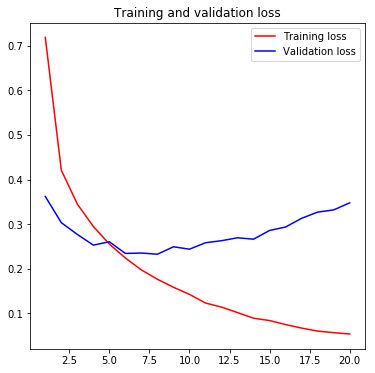

In [36]:
acc = training.history['acc'][0:20]
val_acc = training.history['val_acc'][0:20]
loss = training.history['loss'][0:20]
val_loss = training.history['val_loss'][0:20]
epochs = range(1, len(acc) + 1)


plt.title('Training and validation loss')
plt.plot(epochs, loss, 'red', label='Training loss')
plt.plot(epochs, val_loss, 'blue', label='Validation loss')
plt.legend()

plt.show()

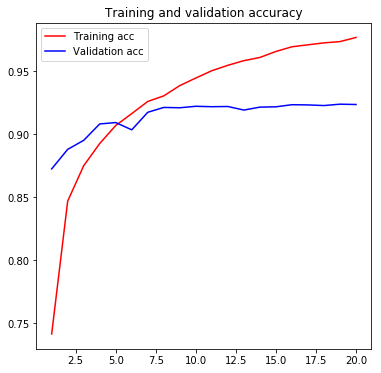

In [23]:
acc = training.history['acc'][0:20]
val_acc = training.history['val_acc'][0:20]
loss = training.history['loss'][0:20]
val_loss = training.history['val_loss'][0:20]
epochs = range(1, len(acc) + 1)

plt.title('Training and validation accuracy')
plt.plot(epochs, acc, 'red', label='Training acc')
plt.plot(epochs, val_acc, 'blue', label='Validation acc')
plt.legend()

plt.show()

#### Test data

In [25]:
model.evaluate(xtest, dtest.T)

10000/10000 [==============================] - 1s 107us/step


[0.35401645753532646, 0.919]

### 2nd Net

In [26]:
predTrain_np=model.predict(xtrain).T.argmax(axis=0)
error_idx=np.where(predTrain_np!=ltrain)[0]
correct_idx=np.where(predTrain_np==ltrain)[0]
n_errors=error_idx.shape[0]
np.random.seed(26)
sample=np.random.choice(correct_idx, 4*n_errors, replace=False)
idx2 = np.concatenate((error_idx, error_idx, sample)) 
np.random.shuffle(idx2)
print('training data for 2nd net: ', len(idx2))

training data for 2nd net:  7152


In [27]:
xtrain2=xtrain[idx2]
ltrain2=ltrain[idx2]

In [28]:
dtrain2 = label2onehot(ltrain2)

In [29]:
xtrain[0].reshape(1,28,28,1).shape

(1, 28, 28, 1)

In [32]:
model.predict(xtrain[0].reshape(1,28,28,1)).T.argmax(axis=0)

array([9])

In [30]:
net2 = Sequential()

net2.add(InputLayer(input_shape=( 28, 28, 1)))
net2.add(BatchNormalization())
net2.add(Conv2D(64, (5, 5), input_shape = ( 60000, 28, 28, 1), activation = 'relu',bias_initializer='RandomNormal', kernel_initializer='random_uniform'))
net2.add(MaxPooling2D(pool_size=(2, 2)))
net2.add(BatchNormalization())
net2.add(Conv2D(512, (5, 5), activation = 'relu'))
net2.add(MaxPooling2D(pool_size=(2, 2)))
net2.add(Flatten())
net2.add(Dense(128, activation='relu'))
net2.add(Dropout(0.35))
net2.add(Dense(64, activation='relu'))
net2.add(Dropout(0.35))
net2.add(Dense(10, activation='softmax'))

print(net2.summary())

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         (None, 28, 28, 1)         0         
_________________________________________________________________
batch_normalization_3 (Batch (None, 28, 28, 1)         4         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 24, 24, 64)        1664      
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 12, 12, 64)        0         
_________________________________________________________________
batch_normalization_4 (Batch (None, 12, 12, 64)        256       
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 8, 8, 512)         819712    
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 4, 4, 512)         0         
__________

In [31]:
net2.compile(optimizer=opt,
              loss='categorical_crossentropy',
              metrics=['accuracy'])

In [32]:
import time
start_time = time.time()
epochs=20
batch_size=64
training = net2.fit(xtrain2, dtrain2.T,
                     epochs=epochs,
                     batch_size=batch_size, 
                     verbose=1, validation_split=0.2)
training_time = time.time() - start_time

Train on 5721 samples, validate on 1431 samples
Epoch 1/20
5721/5721 [==============================] - 2s 317us/step - loss: 1.4918 - acc: 0.4569 - val_loss: 0.9669 - val_acc: 0.6191
Epoch 2/20
5721/5721 [==============================] - 1s 192us/step - loss: 1.2024 - acc: 0.5525 - val_loss: 0.9172 - val_acc: 0.6471
Epoch 3/20
5721/5721 [==============================] - 1s 186us/step - loss: 1.0883 - acc: 0.5828 - val_loss: 0.8366 - val_acc: 0.6688
Epoch 4/20
5721/5721 [==============================] - 1s 191us/step - loss: 1.0076 - acc: 0.6212 - val_loss: 0.8005 - val_acc: 0.6751
Epoch 5/20
5721/5721 [==============================] - 1s 182us/step - loss: 0.9675 - acc: 0.6298 - val_loss: 0.7779 - val_acc: 0.6730
Epoch 6/20
5721/5721 [==============================] - 1s 179us/step - loss: 0.9055 - acc: 0.6565 - val_loss: 0.7759 - val_acc: 0.6869
Epoch 7/20
5721/5721 [==============================] - 1s 184us/step - loss: 0.8748 - acc: 0.6621 - val_loss: 0.7274 - val_acc: 0.7128


In [42]:
net2.save('./models/net_2.h5') 

In [34]:
net2.evaluate(xtest, dtest.T)

10000/10000 [==============================] - 1s 95us/step


[0.47243389432430266, 0.8244]

### 3rd Net

In [35]:
predTrain1 = model.predict(xtrain).T.argmax(axis=0)
predTrain2 = net2.predict(xtrain).T.argmax(axis=0)

In [36]:
error_idx3=np.where(predTrain1!=predTrain2)[0]             # where net1 and net2 disagree
correct_idx3=np.where(predTrain1==predTrain2)[0]
n_errors3=error_idx3.shape[0]
np.random.seed(26)
sample=np.random.choice(correct_idx3, 2*n_errors3, replace=False)
print(n_errors3, len(sample))
idx3 = np.concatenate((error_idx3, sample))       # total 3*n_errors
np.random.shuffle(idx3)
print('training data for 3rd net: ', len(idx3))

9977 19954
training data for 3rd net:  29931


In [37]:
xtrain3=xtrain[idx3]
ltrain3=ltrain[idx3]

In [38]:
dtrain3 = label2onehot(ltrain3)

In [39]:
net3 = Sequential()

net3.add(InputLayer(input_shape=( 28, 28, 1)))
net3.add(BatchNormalization())
net3.add(Conv2D(64, (5, 5), input_shape = ( 60000, 28, 28, 1), activation = 'relu',bias_initializer='RandomNormal', kernel_initializer='random_uniform'))
net3.add(MaxPooling2D(pool_size=(2, 2)))
net3.add(BatchNormalization())
net3.add(Conv2D(512, (5, 5), activation = 'relu'))
net3.add(MaxPooling2D(pool_size=(2, 2)))
net3.add(Flatten())
net3.add(Dense(128, activation='relu'))
net3.add(Dropout(0.35))
net3.add(Dense(64, activation='relu'))
net3.add(Dropout(0.35))
net3.add(Dense(10, activation='softmax'))

print(net2.summary())

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         (None, 28, 28, 1)         0         
_________________________________________________________________
batch_normalization_3 (Batch (None, 28, 28, 1)         4         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 24, 24, 64)        1664      
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 12, 12, 64)        0         
_________________________________________________________________
batch_normalization_4 (Batch (None, 12, 12, 64)        256       
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 8, 8, 512)         819712    
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 4, 4, 512)         0         
__________

In [40]:
net3.compile(optimizer=opt,
              loss='categorical_crossentropy',
              metrics=['accuracy'])

In [41]:
import time
start_time = time.time()
epochs=20
batch_size=64
training = net3.fit(xtrain3, dtrain3.T,
                     epochs=epochs,
                     batch_size=batch_size, 
                     verbose=1, validation_split=0.2)
training_time = time.time() - start_time

Train on 23944 samples, validate on 5987 samples
Epoch 1/20
23944/23944 [==============================] - 5s 226us/step - loss: 1.0539 - acc: 0.6230 - val_loss: 0.6240 - val_acc: 0.7790
Epoch 2/20
23944/23944 [==============================] - 5s 193us/step - loss: 0.7683 - acc: 0.7225 - val_loss: 0.5304 - val_acc: 0.8109
Epoch 3/20
23944/23944 [==============================] - 5s 191us/step - loss: 0.6805 - acc: 0.7536 - val_loss: 0.4903 - val_acc: 0.8216
Epoch 4/20
23944/23944 [==============================] - 4s 187us/step - loss: 0.6258 - acc: 0.7744 - val_loss: 0.4614 - val_acc: 0.8310
Epoch 5/20
23944/23944 [==============================] - 4s 187us/step - loss: 0.5817 - acc: 0.7905 - val_loss: 0.4412 - val_acc: 0.8355
Epoch 6/20
23944/23944 [==============================] - 4s 187us/step - loss: 0.5448 - acc: 0.8014 - val_loss: 0.4295 - val_acc: 0.8432
Epoch 7/20
23944/23944 [==============================] - 4s 183us/step - loss: 0.5108 - acc: 0.8142 - val_loss: 0.4334 - v

### Save 3rd net

In [43]:
net3.save('./models/net_3.h5') 

### Ensemble of the three nets

In [3]:
def apply_ensembling(net1, net2, net3, data, labels):
    pred1 = net1.predict(data)
    pred2 = net2.predict(data)
    pred3 = net3.predict(data)

    predCombined=(pred1+pred2+pred3).T.argmax(axis=0)
    print(np.mean(predCombined==labels), ' after adding all pred')
    
    pred1=np.exp(pred1)
    pred1=pred1/pred1.sum(axis=1).reshape((len(pred3),1))
    pred2=np.exp(pred2)
    pred2=pred2/pred2.sum(axis=1).reshape((len(pred3),1))
    pred3=np.exp(pred3)
    pred3=pred3/pred3.sum(axis=1).reshape((len(pred3),1))
    predCombined=(np.maximum(pred1,pred2,pred3)).T.argmax(axis=0)
    print(np.mean(predCombined==labels), ' after max of all softmax')

In [52]:
apply_ensembling(model, net2, net3, xtest, ltest)
print('\nTraining----------------------------------------')
apply_ensembling(model, net2, net3, xtrain, ltrain)

0.9211  after adding all pred
0.9216  after max of all softmax

Training----------------------------------------
0.9796  after adding all pred
0.9827833333333333  after max of all softmax
